In [1]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from statsmodels.tsa.api import Holt, ExponentialSmoothing

%matplotlib inline

In [2]:
#read data in
location = "covid_19_data.csv"
df = pd.read_csv(location)
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
print(f"Shape: {df.shape}")
print(f"\nCount:\n{df.count()}")
print(f"\nIsnull:\n{df.isnull().sum()}")
print(f"\nD-Types:\n{df.dtypes}")

Shape: (19286, 8)

Count:
SNo                19286
ObservationDate    19286
Province/State      9466
Country/Region     19286
Last Update        19286
Confirmed          19286
Deaths             19286
Recovered          19286
dtype: int64

Isnull:
SNo                   0
ObservationDate       0
Province/State     9820
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

D-Types:
SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [4]:
#Check for duplicates; locate duplicate rows
dupe = df.duplicated()
df.loc[dupe]

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered


In [5]:
#Remove unnecessary columns or columns with too much missing data
df = df.drop(['SNo', 'Province/State', 'Last Update'], axis=1)
#df.head()

In [6]:
#Put 'ObservationDate' into Datetime format
df['ObservationDate']=pd.to_datetime(df['ObservationDate'])
#df.head()

In [7]:
df.corr()

,Confirmed,Deaths,Recovered
Confirmed,1.000000,0.902848,0.648829
Deaths,0.902848,1.000000,0.560395
Recovered,0.648829,0.560395,1.000000


In [8]:
#groupby country
country_df = df[df['ObservationDate']==df['ObservationDate'].max()].groupby(['Country/Region']).agg({'Recovered':'sum', 'Confirmed':'sum', 'Deaths':'sum'}).sort_values(['Confirmed'], ascending=False)
country_df.head()

,Recovered,Confirmed,Deaths
Country/Region,,,
US,111424.0,988197.0,56259.0
Spain,120832.0,229422.0,23521.0
Italy,66624.0,199414.0,26977.0
France,46293.0,165963.0,23327.0
Germany,114500.0,158758.0,6126.0


In [9]:
#groupby date 
date_df = df.groupby(['ObservationDate']).agg({'Recovered':'sum', 'Confirmed':'sum', 'Deaths':'sum'})
date_df.head()

,Recovered,Confirmed,Deaths
ObservationDate,,,
2020-01-22,28.0,555.0,17.0
2020-01-23,30.0,653.0,18.0
2020-01-24,36.0,941.0,26.0
2020-01-25,39.0,1438.0,42.0
2020-01-26,52.0,2118.0,56.0


In [10]:
date_df.corr()

,Recovered,Confirmed,Deaths
Recovered,1.000000,0.990057,0.995425
Confirmed,0.990057,1.000000,0.995628
Deaths,0.995425,0.995628,1.000000


#### Discovery

In [11]:
countries = df['Country/Region'].unique()
print(f"Total Number of countries reporting cases: {len(countries)}")
print(f"Approx. Confirmed cases worldwide: {int(date_df['Confirmed'].iloc[-1])}")
print(f"Approx. Deaths worldwide: {int(date_df['Deaths'].iloc[-1])}")
print(f"Approx. Recovered cases worldwide: {int(date_df['Recovered'].iloc[-1])}")

Total Number of countries reporting cases: 220
Approx. Confirmed cases worldwide: 3041764
Approx. Deaths worldwide: 211167
Approx. Recovered cases worldwide: 893967


In [12]:
#Active = Confirmed - Deaths - Recovered
print(f"Approx. Active cases worldwide: {int(date_df['Confirmed'].iloc[-1]) - int(date_df['Deaths'].iloc[-1]) - int(date_df['Recovered'].iloc[-1])}")


#Closed = Deaths + Recovered
print(f"Approx. Closed cases worldwide: {int(date_df['Deaths'].iloc[-1]) + int(date_df['Recovered'].iloc[-1])}") 

Approx. Active cases worldwide: 1936630
Approx. Closed cases worldwide: 1105134


In [13]:
# Approx. cases per day= case/#rows(total days)
print(f"Approx. Confirmed cases Per Day: {int(int(date_df['Confirmed'].iloc[-1]) / date_df.shape[0])}")
print(f"Approx. Deaths cases Per Day: {int(int(date_df['Deaths'].iloc[-1]) / date_df.shape[0])}")
print(f"Approx. Recovered cases Per Day: {int(int(date_df['Recovered'].iloc[-1]) / date_df.shape[0])}")

Approx. Confirmed cases Per Day: 31358
Approx. Deaths cases Per Day: 2176
Approx. Recovered cases Per Day: 9216


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 <a list of 97 Text xticklabel objects>)

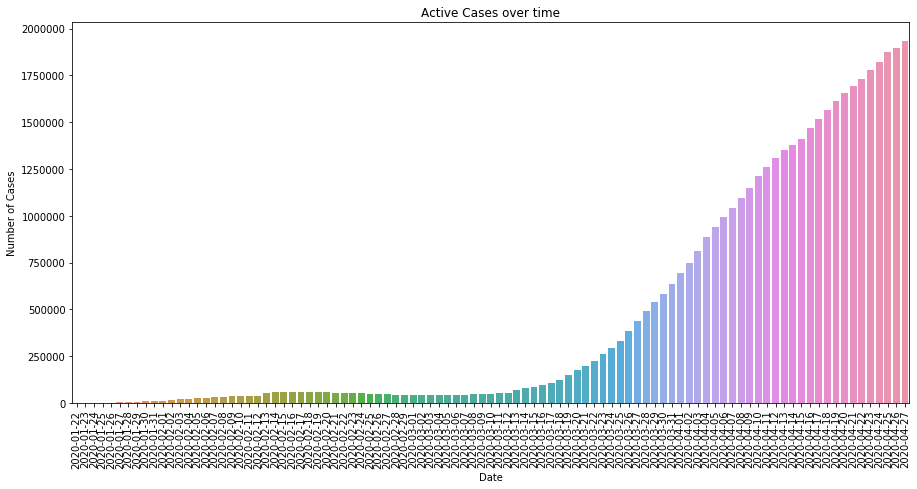

In [14]:
#plot Active cases per date
plt.figure(figsize=(15,7))
sns.barplot(x=date_df.index.date, y=date_df['Confirmed'] - date_df['Deaths'] - date_df['Recovered'])

plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.title("Active Cases over time")
plt.xticks(rotation=90)

#### Growth rate

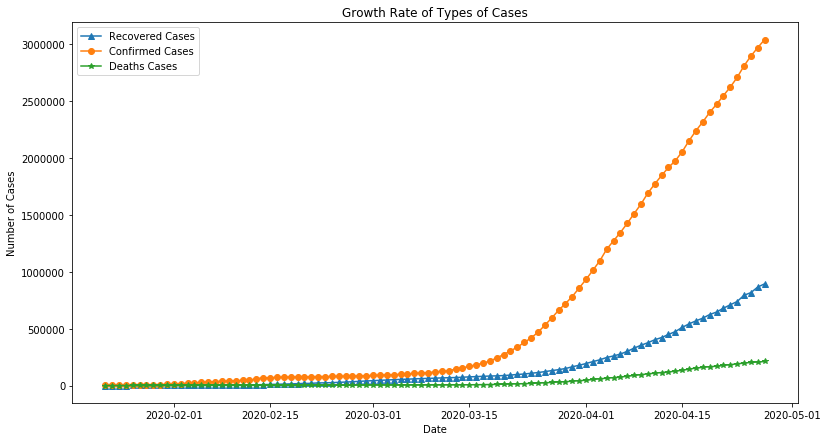

In [15]:
plt.figure(figsize=(13,7))
plt.plot(date_df['Recovered'], marker="^", label="Recovered Cases")
plt.plot(date_df['Confirmed'], marker="o", label="Confirmed Cases")
plt.plot(date_df['Deaths'], marker="*", label="Deaths Cases")


plt.ylabel("Number of Cases")
plt.xlabel("Date")
plt.title("Growth Rate of Types of Cases")
                 
plt.legend()

#### Linear Regression - recovered cases 

In [16]:
#create new col 'Days Since' 
date_df['Days Since'] = date_df.index - date_df.index[0]
date_df['Days Since'] = date_df['Days Since'].dt.days

In [17]:
rows = date_df.shape[0]

In [18]:
trainer = date_df.iloc[:int(rows*0.95)]
tester = date_df.iloc[int(rows*0.25):]

In [19]:
#Initializing Linear Reg Model
lin_reg = LinearRegression(normalize=True)

In [20]:
#Fitting model on training data
lin_reg.fit(np.array(trainer['Days Since']).reshape(-1,1) , np.array(trainer['Recovered']).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [21]:
pred_test_lin = lin_reg.predict(np.array(tester['Days Since']).reshape(-1,1))

#very high error - linear regession is not the best model
rms_error_lin = np.sqrt(mean_squared_error(tester['Recovered'], pred_test_lin))
rms_error_lin

150523.50948521402

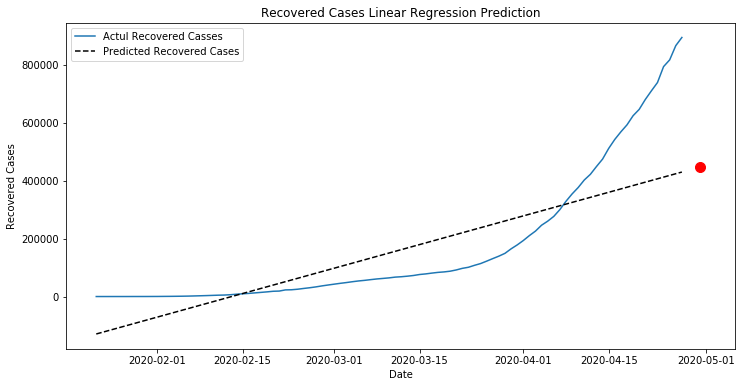

In [43]:
plt.figure(figsize=(12, 6))

pred_linreg = lin_reg.predict(np.array(date_df['Days Since']).reshape(-1,1))

plt.plot(date_df['Recovered'], label="Actul Recovered Casses")
plt.plot(date_df.index, pred_linreg, linestyle='--', label="Predicted Recovered Cases", color='black')

date_object = pd.to_datetime('20200430', format='%Y%m%d', errors='ignore')
plt.scatter(date_object, 447030.288, s=100, color='red')

plt.xlabel("Date")
plt.ylabel("Recovered Cases")
plt.title("Recovered Cases Linear Regression Prediction")
plt.legend()

#### Support Vector Machine Model Regressor

In [23]:
trainer = date_df.iloc[:int(rows*0.75)]
tester = date_df.iloc[int(rows*0.25):]

In [24]:
#Initializing SVR Model
svm = SVR(C=1, degree=5, kernel='poly', epsilon=0.01)

In [25]:
#Fitting model to training data
svm.fit(np.array(trainer['Days Since']).reshape(-1,1), np.array(trainer['Recovered']).reshape(-1,1))

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
pred_test_svm = svm.predict(np.array(tester['Days Since']).reshape(-1,1))

#SVR has very high error as well - still not the best model
rms_error_svm = np.sqrt(mean_squared_error(tester['Recovered'], pred_test_svm))
rms_error_svm

25987.058294887953

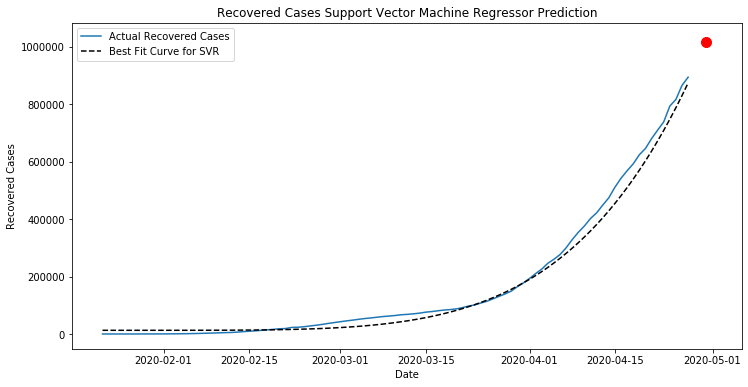

In [44]:
plt.figure(figsize=(12,6))

pred_svm = svm.predict(np.array(date_df['Days Since']).reshape(-1,1))

plt.plot(date_df['Recovered'], label="Actual Recovered Cases")
plt.plot(date_df.index, pred_svm, linestyle='--', label="Best Fit Curve for SVR", color='black')

date_object = pd.to_datetime('20200430', format='%Y%m%d', errors='ignore')
plt.scatter(date_object, 1017263.341, s=100, color='red')

plt.xlabel("Date")
plt.ylabel("Recovered Cases")
plt.title("Recovered Cases Support Vector Machine Regressor Prediction")

plt.legend()

#### Holt's Winter model - exponential smoothing

In [28]:
model_train = date_df.iloc[:int(rows*0.95)]
model_test = date_df.iloc[int(rows*0.95):]

pred_holt = model_test.copy()

In [29]:
Ex_sm = ExponentialSmoothing(np.asarray(model_train['Recovered']), seasonal_periods=8, trend='add', seasonal='mul').fit()

C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [30]:
pred_holt['HoltWM']=Ex_sm.forecast(len(model_test))

rms_error_holt = np.sqrt(mean_squared_error(pred_holt['Recovered'], pred_holt['HoltWM']))
rms_error_holt

17505.20637360353

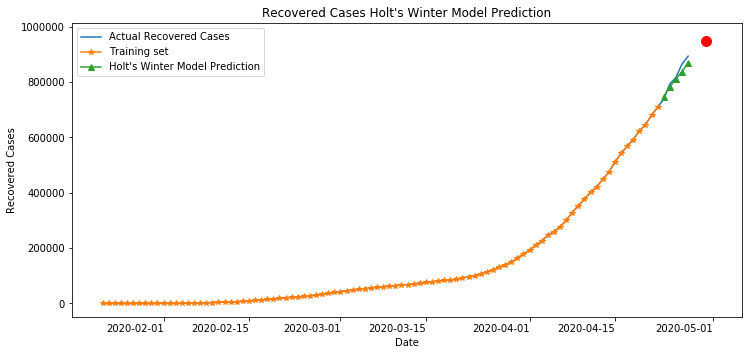

In [46]:
plt.figure(figsize=(12,6))

plt.plot(date_df['Recovered'], label="Actual Recovered Cases")
plt.plot(model_train.Recovered, label="Training set", marker='*')
pred_holt['HoltWM'].plot(label="Holt's Winter Model Prediction", marker='^')

date_object = pd.to_datetime('20200430', format='%Y%m%d', errors='ignore')
plt.scatter(date_object, 948588.749, s=100, color='red')

plt.ylabel("Recovered Cases")
plt.xlabel("Date")
plt.title("Recovered Cases Holt's Winter Model Prediction")

plt.xticks(rotation=360)
plt.legend()

#### Model Comparison

In [32]:
new_date = []
new_pred_lr = []
new_pred_svm = []
new_pred_holt = []

for day in range(0,5):
    new_date.append(date_df.index[-1] + timedelta(days=day))
    new_pred_lr.append(lin_reg.predict(np.array(date_df['Days Since'].max() + day).reshape(-1,1))[0][0])
    new_pred_svm.append(svm.predict(np.array(date_df['Days Since'].max() + day).reshape(-1,1))[0])
    new_pred_holt.append(Ex_sm.forecast((len(model_test)+day))[-1])
print(new_pred_holt)

[870749.4777816287, 894224.0691088504, 926732.5874790562, 948588.7494594525, 994870.6971927033]


In [33]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_pred_lr, new_pred_svm, new_pred_holt), columns=["Dates", "Linear Regression Prediction", "SVM Prediction", "Holt's Winter Model Prediction"])

In [34]:
model_predictions

,Dates,Linear Regression Prediction,SVM Prediction,Holt's Winter Model Prediction
0,2020-04-27,429569.639,874025.551,870749.478
1,2020-04-28,435389.855,919823.384,894224.069
2,2020-04-29,441210.071,967549.232,926732.587
3,2020-04-30,447030.288,1017263.341,948588.749
4,2020-05-01,452850.504,1069027.196,994870.697


#### Reformating dataframe - visualizations

In [35]:
melt_df = pd.melt(df, id_vars=['ObservationDate', 'Country/Region'], var_name="Status")
melt_df.head()

,ObservationDate,Country/Region,Status,value
0,2020-01-22,Mainland China,Confirmed,1.000
1,2020-01-22,Mainland China,Confirmed,14.000
2,2020-01-22,Mainland China,Confirmed,6.000
3,2020-01-22,Mainland China,Confirmed,1.000
4,2020-01-22,Mainland China,Confirmed,0.000
